# Cel

Celem zadania jest oszacowanie energii wiązania represora ekspresji enzymu lacZ przeez represor lacl, który wiąże się do dokłądnie jednego miejsca przy miejscu startu transkrypcji.

W pracy [2] wyprowadzony został wzór określający krotność zmiany transkrypcji w zależności od różnych parametrów:

$foldchange= (1 + \frac{R}{N_{NS}} e^{-\Delta\epsilon_r/k_BT})^{-1}$,

gdzie: 
* $R$ - średnia liczba represorów na komórkę
* $N_{NS}$ - liczba możliwych miejsc wiązań dla represora
* $k_BT$ - energia cieplna sytemu
* $\Delta\epsilon_r$ - (szukana) energia wiązania represora

# Odtworzenie wyników analizy z [1]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib.image as pimg

W pierwszym kroku po
bieramy przykładowe dane z pliku csv i prezentujemy je na wykresie logarytmicznym

In [3]:
#lacZ_titration_data = np.genfromtxt('lacZ_titration_data-2.csv', delimiter=',', usecols = (0, 1), names=True)
lacZ_titration_data = np.loadtxt('lacZ_titration_data-2.csv', delimiter=',', skiprows=1, usecols = (0,1))

Dane, wczytane jako macierz, pierwsza kolumna odpowiada średniej liczbie represorów w badanych komórkach ($R$), a druga kolumna zmianie stopnia ekspresji genu (**fold-change**). Wszystkie dane z pliku są dla operatora O2, więc kolumna ta została pominięta przy parsowaniu.

In [4]:
lacZ_titration_data

array([[2.242e+01, 1.756e-01],
       [5.934e+01, 4.519e-02],
       [1.240e+02, 2.151e-02],
       [2.553e+02, 1.241e-02]])

(10, 1000.0)

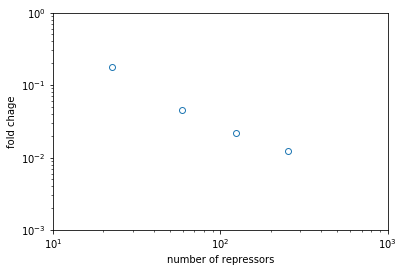

In [5]:
repressors = lacZ_titration_data.T[0]
foldChange = lacZ_titration_data.T[1]

plt.loglog(repressors, foldChange, 'o', markerfacecolor='w')
plt.xlabel('number of repressors')
plt.ylabel('fold chage')
plt.ylim([1e-3, 1])
plt.xlim([10, 1e3])

### Statystyka $\chi^2$

$\chi^2 = \displaystyle\sum_i \frac{(y_i - y(\alpha))^2}{\sigma_i^2}$

* $y_i$ - i-ta dana
* $y(\alpha)$ - wartość przewidywana y
* $\sigma_i^2$ - wariancja danych

Warotść $\alpha$, która minimalizuje $\chi^2$ uznwana jest za najlepsze dopasowanie parametru.

### Poszukiwanie najlepszej $\alpha$

Znamy zatem $R$, $N_{NS}$, **fold-change**, $k_BT$ (z definicji). Możemy, więc przystąpić do wynaczenia $\Delta\epsilon_r$.

Od wartości $\Delta\epsilon_r$ wymagamy, by minimalizowała różnicę pomiędzy zmierzonym, a przewidywanym **fold-change**.

Na początek zrobimy to metodą "na oko". Utworzymy wektor **epRange**, który rozpina nam wiele możliwych wartości $\Delta\epsilon_r$, po czym, obliczymy statystykę $\chi^2$ dla każdej z nich. Na wartości w **epRange** narzucimy pewne ograniczenia:

* $\Delta\epsilon_r < 0$ - zakładamy, że energia jest nieujemna, ponieważ represor posiada pewne powinowactwo do swojego miejsca wiążącego
* $\Delta\epsilon_r > -30 k_BT$ - energia powinna być mniejsza od najmocniejszego znanego [1] wiązania niekowalencyjnego (represor również wiąże się niekowalencyjnie

Text(0, 0.5, 'X^2')

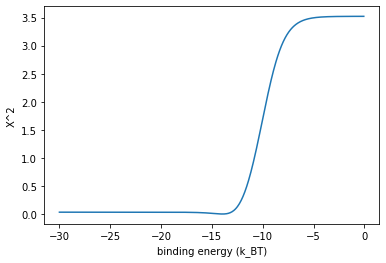

In [6]:
epRange = np.arange(-30, 0, 30/500)

chiSq = []

for ep in epRange:
    theoretical = (1 + (repressors/5e6) * np.exp(-ep))**-1
    chiSq.append(np.sum((theoretical - foldChange)**2))

plt.plot(epRange, chiSq)
plt.xlabel('binding energy (k_BT)')
plt.ylabel('X^2')

Minimum możemy łatwiej zaobserować po logarytmicznym przeskalowaniu wartości y:

Text(-10, 0.01, 'minimum')

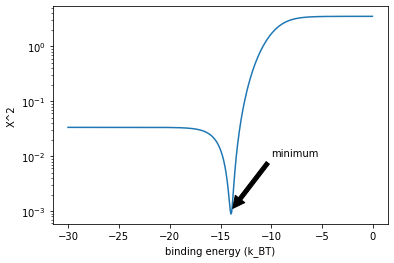

In [7]:
plt.semilogy(epRange, chiSq)
plt.xlabel('binding energy (k_BT)')
plt.ylabel('X^2')

plt.annotate('minimum', xy=(-14, 1e-3), xytext=(-10, 1e-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

Próbujemy dopasować funkcję. Badamy dla 3 przypadków $\Delta\epsilon$:
* dobrego dopasowania, z wykresu szacujemy na -14 $k_BT$
* złego dopasowania: -20 oraz -10 $k_BT$

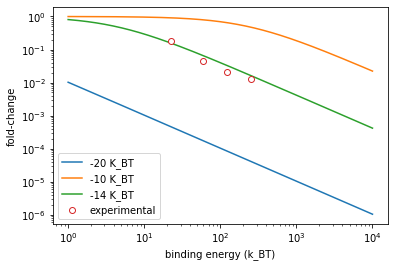

In [15]:
badEp1 = -20
badEp2 = -10
bestEp = -14

repRange = np.logspace(0, 4, 500)

epValues = np.array([badEp1, badEp2, bestEp])

repressors = lacZ_titration_data.T[0]
foldChange = lacZ_titration_data.T[1]

fits = []

for epValue in epValues:
    fits.append((1 + (repRange / 5E6) * np.exp(-epValue))**-1);

plt.loglog(repRange, fits[0], label='-20 K_BT')
plt.loglog(repRange, fits[1], label='-10 K_BT')
plt.loglog(repRange, fits[2], label='-14 K_BT')

plt.loglog(repressors, foldChange, 'o', markerfacecolor='w', label='experimental')

plt.xlabel('binding energy (k_BT)')
plt.ylabel('fold-change')

plt.legend()

Widzimy, że $\Delta\epsilon = -14 k_BT$ jest dobrym dopasowaniem, ponieważ ładnie pokrywa się z danymi eksprymentalnymi.

## Optymalizacja przy użyciu algorytmu Levenberga-Marquardta

Szukanie minimum można usprawnić przez zastosowanie algorytmów optymalizacyjnych. Poniższy kod poszukuje rozwiązania przez zastosowanie algorytmu Levenberga-Marquardta, który łączy ze sobą metodę największego spadku gradientu oraz metodę Gaussa-Newtona (która uwzględnia także drugą pochodną):

In [16]:
def residFunc(ep):
    theoretical = (1 + (repressors/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChange)**2)

result = sp.least_squares(residFunc, [-14], method='lm')

print(f"Binding energy: {result.x}")

Binding energy: [-13.96154072]


Znaleziona energia wiązania: $-13.96  k_BT$

## Testy dla operonów O1 i O3

Dane testowe pobrane zostały odpowiednio do plików lacZ-O1.csv oraz lacZ-O3.csv, a uzyskane przez przetworzenie wykresu S7B z supplementu do [2] w programie PlotDigitalizer [3]. Dne dla operonów O1, O2, O3 zostały odpowiednio pobrane do plików *lacZ-O1.csv*, *lacZ-O2.csv*,  *lacZ-O3.csv*.

### Operon O1

* Znalezione minimum: **-16.3**
* Oczekiwane minimum: **-15.3** $\pm$ 0.2

In [10]:
O1_data = np.loadtxt('lacZ-O1.csv', delimiter=',', skiprows=1)
print(f"O1 data:\n {O1_data}")
repressorsO1 = O1_data.T[0]
foldChangeO1 = O1_data.T[1]

def residFuncO1(ep):
    theoretical = (1 + (repressorsO1/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO1)**2)

result_O1 = sp.least_squares(residFuncO1, [-14], method='lm')

print(f"Binding energy: {result_O1.x}")


O1 data:
 [[1.12176733e+01 3.89927439e-02]
 [2.96352207e+01 8.86473151e-03]
 [6.17543466e+01 4.68805559e-03]
 [1.27537637e+02 2.74132202e-03]
 [6.08396419e+02 1.49790367e-03]
 [8.66529872e+02 1.09296856e-03]]
Binding energy: [-16.28168779]


### Operon O3

* Znalezione minimum: **-10.8**
* Oczekiwane minimum: **-9.7** $\pm$ 0.1

In [11]:
O3_data = np.loadtxt('lacZ-O3.csv', delimiter=',', skiprows=1)
print(f"O3 data:\n {O3_data}")
repressorsO3 = O3_data.T[0]
foldChangeO3 = O3_data.T[1]

def residFuncO3(ep):
    theoretical = (1 + (repressorsO3/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO3)**2)

result_O3 = sp.least_squares(residFuncO3, [-14], method='lm')

print(f"Binding energy: {result_O3.x}")

O3 data:
 [[1.12176733e+01 7.99804416e-01]
 [2.96352207e+01 6.53584810e-01]
 [6.20314303e+01 6.19039185e-01]
 [1.27537637e+02 4.73206785e-01]
 [6.05678817e+02 2.48383153e-01]
 [8.66529872e+02 1.74096279e-01]]
Binding energy: [-10.83013728]


### Operon O2

Sprawdzenie wyników dla operonu O2, tym razem dla danych wyciągniętych z wykresu:
* Znalezione minimum: **-14.7**
* Oczekiwane minimum: **-13.9** $\pm$ 0.2

Zauważmy, że błąd energii wiązania dla danych wyciągniętych z wykresu przy użyciu PlotDigitilizer wynosi dla operona O2: **0.8** w porównaniu do wyniku otrzymanego dla danych z pliku csv. Dodatkowo, zauważyliśmy, że wynik dla O1 jest dużo bardziej wrażliwy na zmiany, co wynika prawdopodobnie z dużo niższych i bliżej siebie leżących wartości fold-change, podjerzewamy więc, że różnice między wynikami z naszego programu, a wynikami z artykułu wynikają z błędów odczytu warotści z wykresu z artykułu przez PlotDigitilizer.

In [12]:
O2_data = np.loadtxt('lacZ-O2.csv', delimiter=',', skiprows=1)
print(f"O2 data:\n {O2_data}")
repressorsO2 = O2_data.T[0]
foldChangeO2 = O2_data.T[1]

def residFuncO2(ep):
    theoretical = (1 + (repressorsO2/5e6) * np.exp(-ep))**-1
    return np.sum((theoretical - foldChangeO2)**2)

result_O2 = sp.least_squares(residFuncO2, [-14], method='lm')

print(f"Binding energy: {result_O2.x}")

O2 data:
 [[1.12176733e+01 1.74831692e-01]
 [2.97681901e+01 4.51411680e-02]
 [6.20314303e+01 2.14464051e-02]
 [1.27537637e+02 1.22912603e-02]
 [6.08396419e+02 5.68058388e-03]
 [8.70417879e+02 4.58301459e-03]]
Binding energy: [-14.65756153]


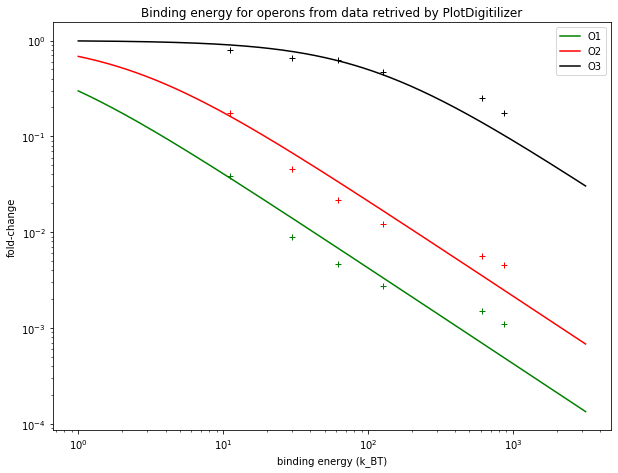

In [13]:
repRange = np.logspace(0, 3.5, 500)

epValues = np.array([result_O1.x, result_O2.x, result_O3.x])

fits = []

for epValue in epValues:
    fits.append((1 + (repRange / 5E6) * np.exp(-epValue))**-1);

plt.figure(figsize = [10, 10/6.4*4.8])
plt.loglog(repressorsO1, foldChangeO1, 'g+');
plt.loglog(repressorsO1, foldChangeO2, 'r+', markerfacecolor='w');
plt.loglog(repressorsO1, foldChangeO3, 'k+', markerfacecolor='w');

plt.loglog(repRange, fits[0], 'g', label='O1')
plt.loglog(repRange, fits[1], 'r', label='O2')
plt.loglog(repRange, fits[2], 'k', label='O3')

plt.xlabel('binding energy (k_BT)')
plt.ylabel('fold-change')
plt.title('Binding energy for operons from data retrived by PlotDigitilizer')

plt.legend()

Oryginalny wykres z suplementu do artykułu:

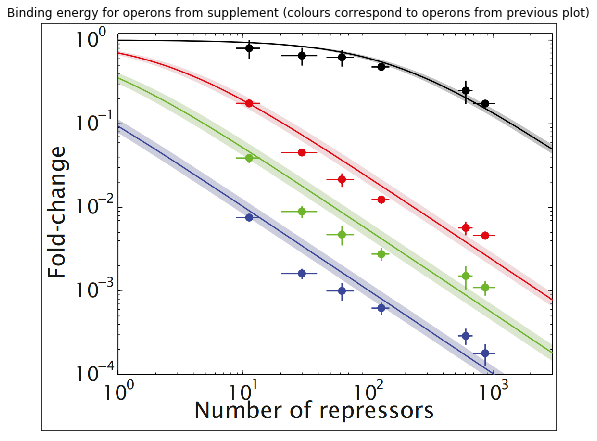

In [14]:
plot_from_supplement = pimg.imread('plot.png')

plt.figure(figsize = [10, 10/6.4*4.8])
imgplot = plt.imshow(plot_from_supplement)

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.title('Binding energy for operons from supplement (colours correspond to operons from previous plot)')

plt.show()

## Obserwacje

* Możemy zauważyć, że przyjęty model dosyć precyzyjnie oddaje rzeczywistość oraz że przyjęta metoda regresji pozwala znaleźć szukane wartości dla danego zbioru danych
* Możemy również zaobserwować, że dane wyciągnięte z wykresu metodą wsteczej inżynierii przy użyciu narzędzia PlotDigitilizer obarczone są większym błędem, który wpływa na wyniki tym bardziej im dane są bliżej 0

## Referencje
[1] Nonlinear Regression - matriał z kursu do ćwiczeń

[2] Garcia, H. G., & Phillips, R. (2011). Quantitative dissection of the simple repression input-output function. *Proceedings of the National Academy of Sciences of the United States of America, 108(29)*, 12173ˀ12178.
https://doi.org/10.1073/pnas.1015616108

[3] PlotDigitilizer (https://apps.automeris.io/wpd/)